In [9]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt

# Load data
def read_mortality_csv(zip_file):
  import io
  import csv
  fields, cities, values = None, [], []
  with io.TextIOWrapper(zip_file.open('data_and_materials/mortality.csv')) as wrap:
    csv_reader = csv.reader(wrap, delimiter=',', quotechar='"')
    fields = next(csv_reader)[1:]
    for row in csv_reader:
      cities.append(row[0])
      values.append(tuple(map(float, row[1:])))
  dtype = np.dtype([(name, float) for name in fields])
  #print(np.array(values, dtype=dtype).view(np.recarray))
  return cities, fields, np.array(values, dtype=dtype).view(np.recarray)

with zipfile.ZipFile("statsreview_release1.zip") as zip_file:
  syn_X, syn_y = ( np.loadtxt(zip_file.open('data_and_materials/{}'.format(fname)), delimiter=',') for fname in ['syn_X.csv', 'syn_y.csv'] )
  m_cities, m_fields, m_values = read_mortality_csv(zip_file)

In [11]:
print(syn_y)

[ -1.0449    7.6819   -0.68642   5.6385    1.0843    3.3899   -0.59445
  -1.3867   -1.4906    6.1239    9.7367   10.261    -3.6631    6.5071
  -1.8226    0.60871  -4.7102   12.475     5.3455    9.0114  -10.812
  -2.3607   -2.7273    8.6033    3.9424    4.2454   -2.1486    3.0243
  -0.93487  10.51      4.8543    3.7043    7.3401   -1.6278   -3.056
   3.4151    8.398    -5.4942    1.84      1.9132    1.241     3.3561
  10.434     3.6464    4.7945    5.5878    6.9637    5.9562   12.373
  -0.98722  -1.7437    2.1675    0.8157    4.4687   -2.7787    4.3204
   5.3036   -4.7648    3.8555    6.1602    2.515     5.0227    7.4086
  -8.1853   -3.3853   -0.11589   6.1029    4.3974    1.5536    1.5854
   7.4188   13.923     8.7931    1.2401   -0.55038  -2.1875    0.21854
   2.2216    3.9299   -2.1418   10.286     0.59956   6.2317    6.0374
  -0.98799  -1.7201    7.6863   -4.2912   -0.11579   0.10047   1.4887
   2.1307    4.7409    5.4297    0.96951  -1.5279   -6.2135   -2.1302
   1.3207   -4.1266 ]

Part (a)

In [12]:
def add_intercept(X):
  return np.concatenate((np.ones_like(X[:,:1]), X), axis=1)

def matrix_inverse_OLS(X, y):
  return linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

import numpy.linalg as linalg
beta_hat = matrix_inverse_OLS(add_intercept(syn_X), syn_y)
print(beta_hat)

[ 1.92960603  1.26397096 -4.59799331]


In [17]:
print((np.ones_like(syn_X[:,:1])))

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


Part (b)

In [19]:
def loss_fn(beta, X, y):
  # (y - X beta)^T (y - X beta)
  return np.sum(np.square(y - X.dot(beta)))

def loss_grad(beta, X, y):
  # -2*(y - X beta)^T X
  return -2*(y - X.dot(beta)).T.dot(X)

def gradient_step(beta, step_size, X, y):
  loss, grads = loss_fn(beta, X, y), loss_grad(beta, X, y)
  # beta_(i+1) = beta_i - alpha (del f)^T
  beta = beta - step_size * grads.T
  return loss, beta

def gradient_descent(X, y, step_size, precision, max_iter=10000, warn_max_iter=True):
  beta = np.zeros_like(X[0])
  losses = [] # Array for recording the value of the loss over the iterations.
  graceful = False
  for _ in range(max_iter):
    beta_last = beta # Save last values of beta for later stopping criterion
    loss, beta = gradient_step(beta, step_size, X, y)
    losses.append(loss)
    # Use the norm of the difference between the new beta and the old beta as a stopping criteria
    if np.sqrt(np.sum(np.square((beta - beta_last)/beta))) < precision:
      graceful = True
      break
  if not graceful and warn_max_iter:
    print("Reached max iterations.")
  return beta, np.array(losses)


BetaHat = [ 1.92960603  1.26397096 -4.5979933 ]


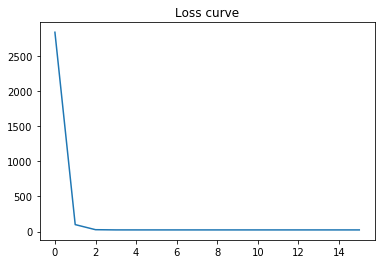

Optimal step size is 0.0042000000000000015 with 9.0 steps


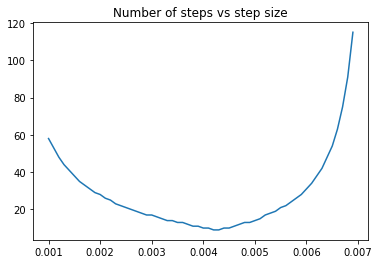

In [25]:
# In my experimentation, it seems a step size of 0.004 converges the fastest
beta_gd, losses = gradient_descent(add_intercept(syn_X), syn_y, 0.004, 1e-8)
print("BetaHat = {}".format(beta_gd))
plt.plot(range(len(losses)), losses)
plt.title("Loss curve")
plt.show()
# Now run a scan over the step size in order to confirm this
step_size_scan_range = np.arange(0.001, 0.007, 0.0001)
step_scan = np.array([ (step_size, len(gradient_descent(syn_X, syn_y, step_size, 1e-6, warn_max_iter=False)[1])) for step_size in step_size_scan_range ]).T
#print(step_scan[2])
print("Optimal step size is {} with {} steps".format(*step_scan[:, np.argmin(step_scan[1])]))
plt.plot(step_scan[0], step_scan[1])
plt.title("Number of steps vs step size")
plt.show()

Part (c-1)

/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys
/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':


Reached max iterations.
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
nan


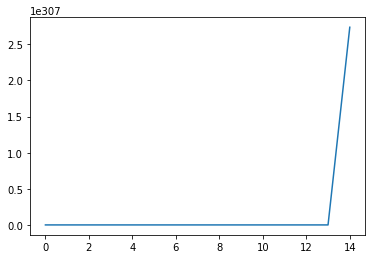

In [26]:
m_y = m_values.Mortality
m_X = np.array([ m_values[f] for f in m_fields if f != 'Mortality']).T # Arrange our X matrix in the same order as the data set, but without the Mortality column.
# Then run the gradient descent, notice the many overflow warnings and the result is all NaNs
m_beta_gd, m_losses = gradient_descent(add_intercept(m_X), m_y, 0.0001, 1e-6, max_iter=100000)
print(m_beta_gd)
print(m_losses[-1])
plt.plot(range(len(m_losses)), m_losses)
plt.show()

Part (c-2)

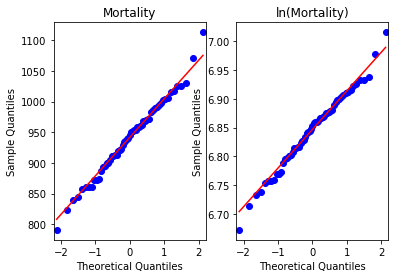

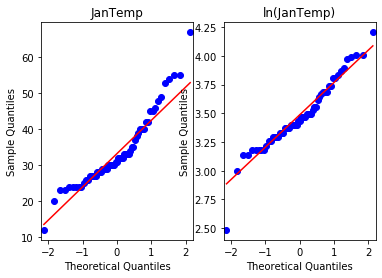

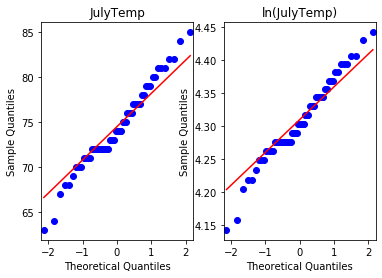

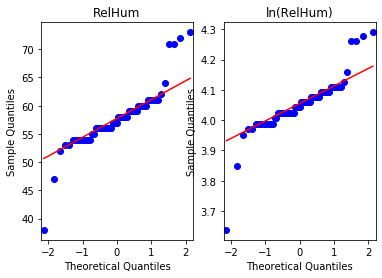

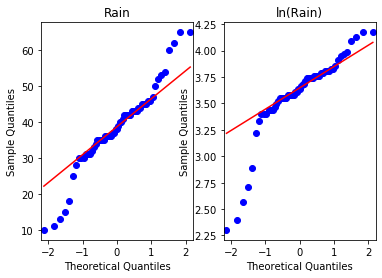

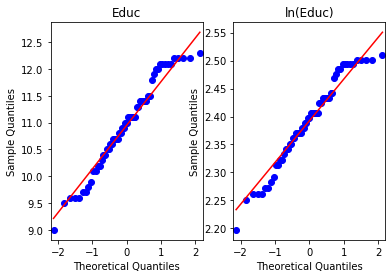

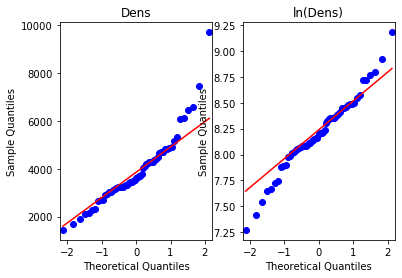

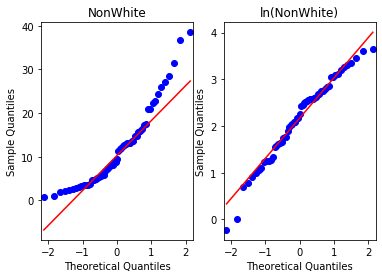

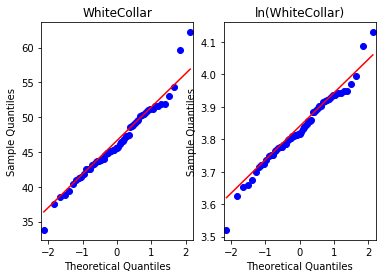

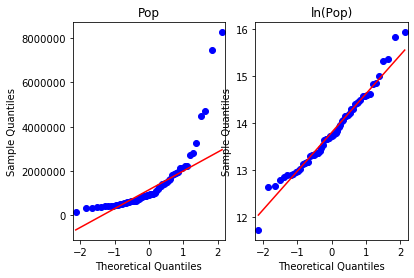

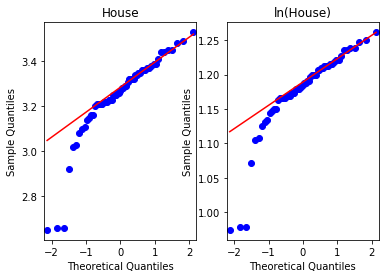

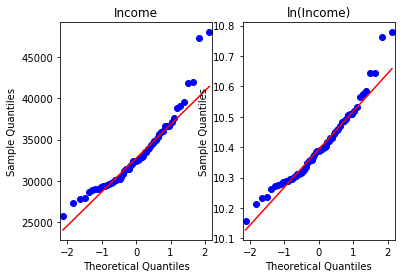

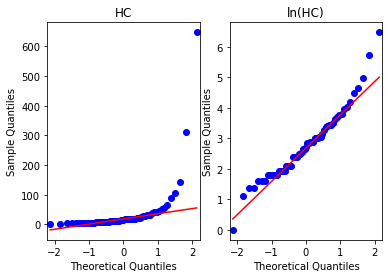

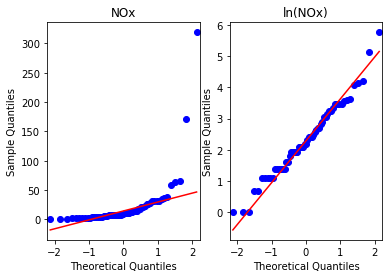

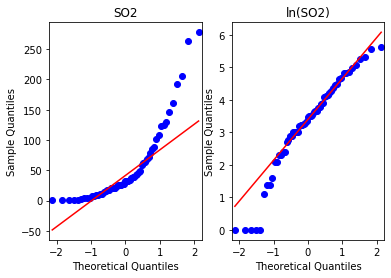

In [29]:
import statsmodels.api as sm
# Here we will make a matrix of Q-Q plots for easy comparison.
for f in m_fields:
  fig = sm.qqplot(m_values[f], line='q', ax=plt.subplot(1, 2, 1))
  plt.title(f)
  fig = sm.qqplot(np.log(m_values[f]), line='q', ax=plt.subplot(1, 2, 2))
  plt.title("ln({})".format(f))
  plt.show()
# The first thing we can notice from this is the very wide range of values that some variables take

BetaHat = [-3.28181926e-16 -2.34383116e-01 -2.17493736e-01  1.17209906e-02
  1.79782475e-01 -1.50536098e-01  1.08944132e-01  7.64354041e-01
 -1.21215180e-01  8.40237061e-02 -1.11470088e-01 -3.04636564e-02
 -9.95566976e-01  8.80412580e-01  8.62045875e-02]
Final loss value = 13.809259456199976


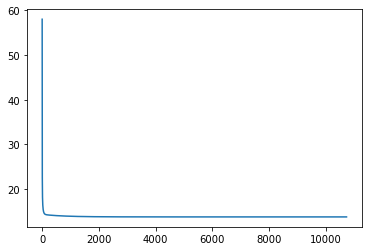

Matrix inverse BetaHat = [-3.34928191e-16 -2.34377091e-01 -2.17496828e-01  1.17238925e-02
  1.79754504e-01 -1.50544513e-01  1.08945825e-01  7.64348559e-01
 -1.21202349e-01  8.40325965e-02 -1.11479218e-01 -3.04687337e-02
 -9.96190618e-01  8.81043305e-01  8.61146149e-02]


In [30]:
# To combat this, we scale these values by their mean and standard deviation.
# Note we also do this for y
m_X_scaled = (m_X - m_X.mean(axis=0))/m_X.std(axis=0, ddof=1)
m_Y_scaled = (m_y - m_y.mean())/m_y.std(ddof=1)
m_X_inter = add_intercept(m_X_scaled)
# Running gradient descent now works.
m_beta_gd, m_losses = gradient_descent(m_X_inter, m_Y_scaled, 0.001, 1e-6, max_iter=100000)
print("BetaHat = {}".format(m_beta_gd))
print("Final loss value = {}".format(m_losses[-1]))
plt.plot(range(len(m_losses)), m_losses)
plt.show()
# As a sanity check, we can also do the matrix inversion 
print("Matrix inverse BetaHat = {}".format(matrix_inverse_OLS(m_X_inter, m_Y_scaled)))

Part (d)

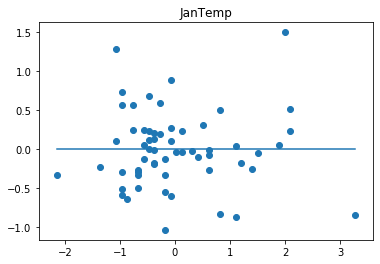

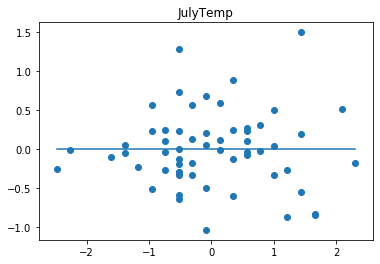

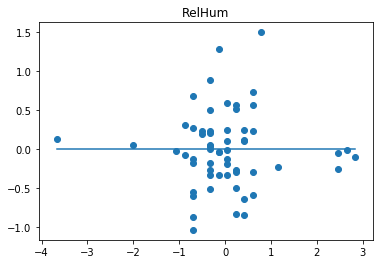

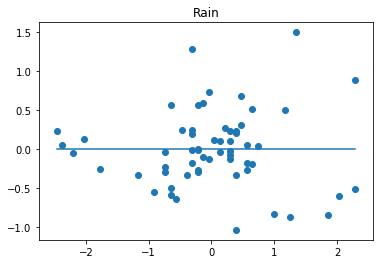

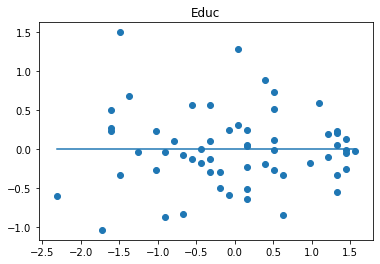

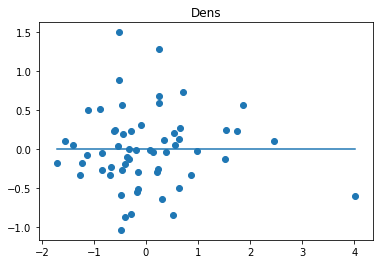

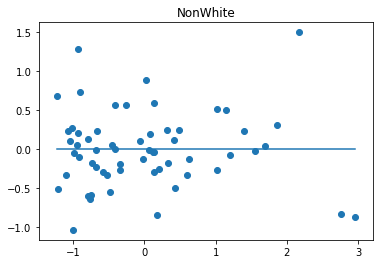

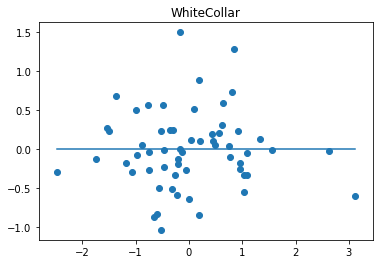

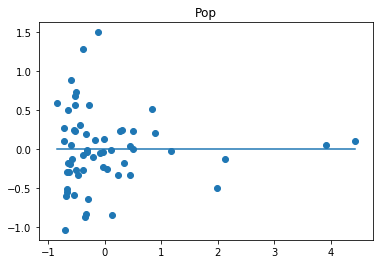

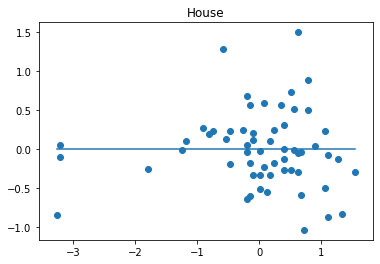

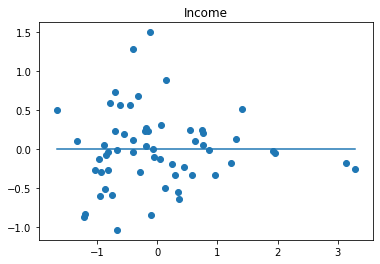

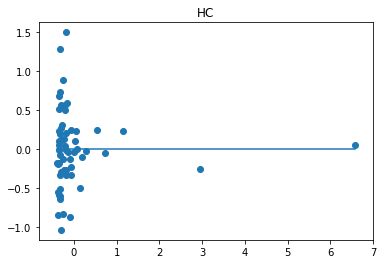

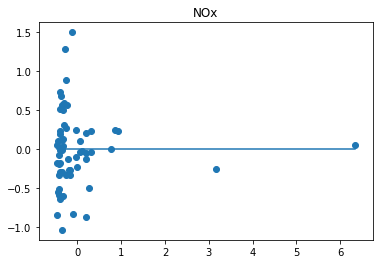

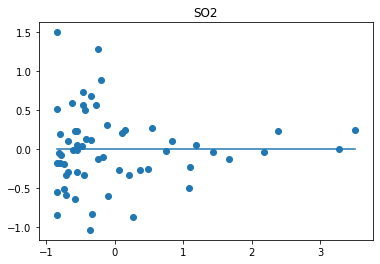

In [31]:
# Here we plot the residuals, so assess the quality of the fit
for i, f in enumerate([ f for f in m_fields if f != 'Mortality']):
  plt.plot(sorted(m_X_scaled.T[i]), np.zeros_like(m_Y_scaled))
  plt.scatter(m_X_scaled.T[i], m_Y_scaled - m_X_inter.dot(m_beta_gd))
  plt.title(f)
  plt.show()

Reached max iterations.
BetaHat = [-2.77731343e-17  1.00000000e+00 -5.94627483e-15 -6.78078144e-16
  2.70500436e-16  7.59629733e-15 -2.95540451e-15  3.02324346e-16
  9.63135377e-15 -2.34567417e-15  1.33597485e-15 -7.09583599e-16
 -1.43727639e-15 -4.84043096e-15  1.22903176e-14 -1.90772570e-15]
Final loss value = 4.903638626023602e-27


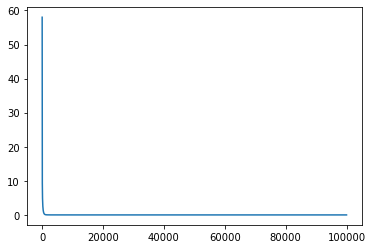

In [32]:
# From the residuals, and the Q-Q plots, we find the following variables deviate significantly from normality: ['NonWhite','Pop','HC','NOx','SO2']
# So we perofrm a log transform on the _non-scaled_ values
m_X_transformed = np.array([ m_values[f] if f not in ['NonWhite','Pop','HC','NOx','SO2'] else np.log(m_values[f]) for f in m_fields ]).T
# After the transform, we then rescale all variables accroding to the new means and standard deviations
m_X_transformed_scaled = (m_X_transformed - m_X_transformed.mean(axis=0))/m_X_transformed.std(axis=0, ddof=1)
m_X_ts_inter = add_intercept(m_X_transformed_scaled)
# Then perform the gradient descent again
m_beta_gd, m_losses = gradient_descent(m_X_ts_inter, m_Y_scaled, 0.0001, 1e-6, max_iter=100000)
print("BetaHat = {}".format(m_beta_gd))
print("Final loss value = {}".format(m_losses[-1]))
plt.plot(range(len(m_losses)), m_losses)
plt.show()

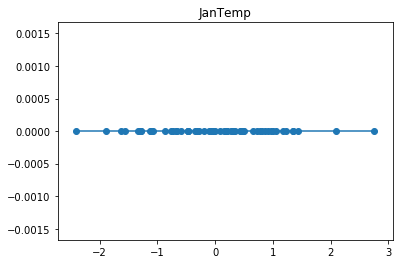

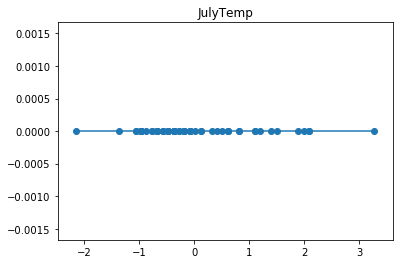

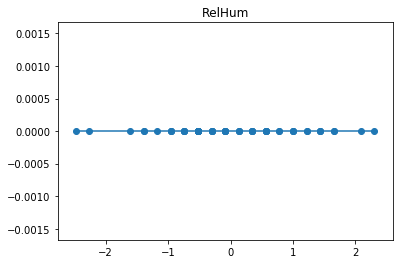

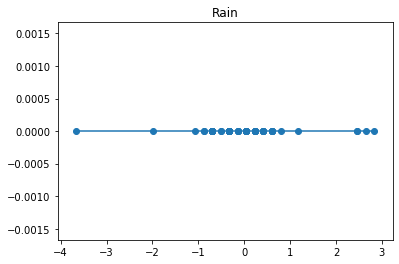

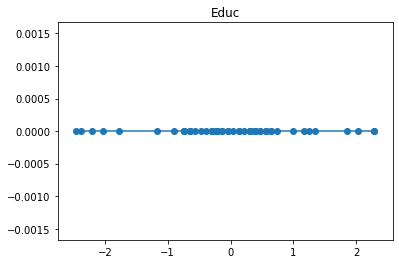

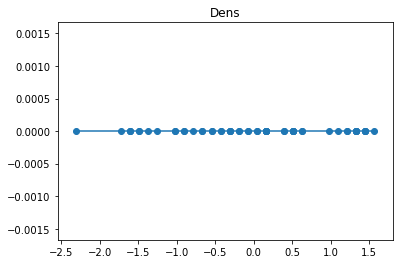

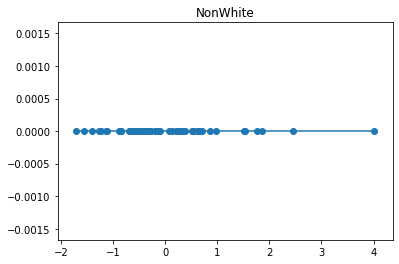

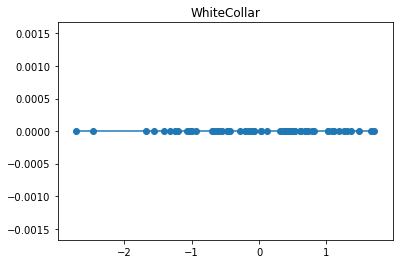

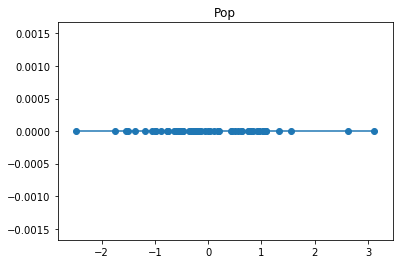

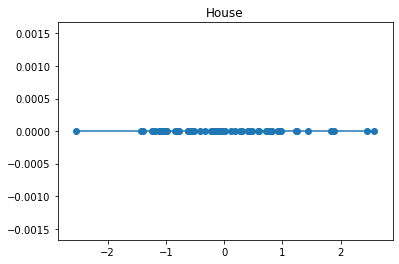

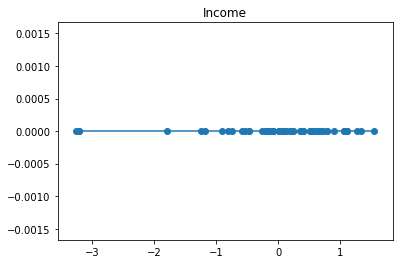

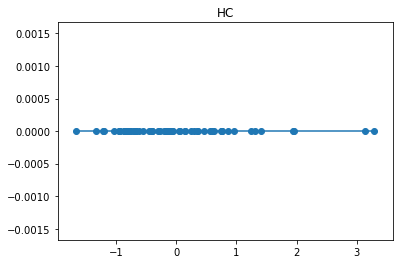

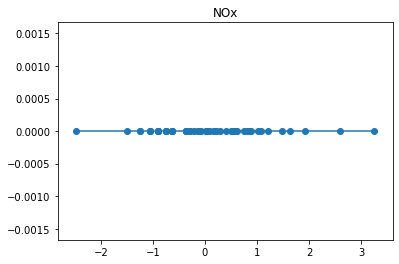

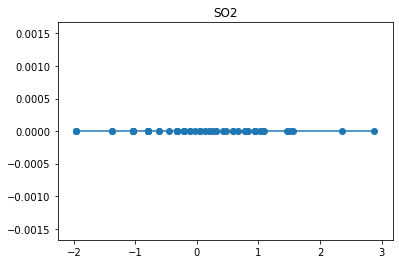

In [33]:
# The transformed variables give a much better fit, with a greatly improved loss value.
# We can also plot the residuals again, and we see that they are also improved.
for i, f in enumerate([ f for f in m_fields if f != 'Mortality']):
  plt.plot(sorted(m_X_transformed_scaled.T[i]), np.zeros_like(m_Y_scaled))
  plt.scatter(m_X_transformed_scaled.T[i], m_Y_scaled - m_X_ts_inter.dot(m_beta_gd))
  plt.title(f)
  plt.show()